# iModulon Characterization:
# Remaining iModulons

## Setup
This IPython notebook continues from the first two iModulon Characterization notebook and will walk through the steps of characterizing iModulons through semi-automated tools, specifically looking at the remaining iModulons that could not be characterized through known TRN from literature or from KEGG enrichments. You will need:

* M and A matrices
* Expression data (e.g. `log_tpm_norm.csv`)
* Gene table and KEGG/GO annotations (Generated in `gene_annotation.ipynb`)
* Sample table, with a column for `project` and `condition`
* TRN file

In [1]:
from os import path
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm
from pymodulon.core import IcaData
from pymodulon.util import explained_variance
from pymodulon.compare import *
from pymodulon.io import *
from pymodulon.plotting import *

In [2]:
# Enter the location of your data here
data_dir = '../data/'

In [3]:
# Load in metadata & TRN files
df_metadata = pd.read_csv(path.join(data_dir,'metadata_qc.csv'),index_col=0)
df_trn = pd.read_csv(path.join(data_dir,'saci_trn_curated_01_01_2021.tsv'),sep='\t')

# Load in other files to generate IcaData object
ica_data = IcaData(M = path.join(data_dir,'ica_runs/80/S.csv'),
                   A = path.join(data_dir,'ica_runs/80/A.csv'),
                   X = path.join(data_dir,'log_tpm_norm.csv'),
                   gene_table = path.join(data_dir,'gene_info_curated_Jan_07_2021.tsv'),
                   sample_table = path.join(data_dir,'metadata_qc.csv'),
                   trn = path.join(data_dir,'saci_trn_curated_01_01_2021.tsv'),
                   threshold_method = 'kmeans')

### iModulon Table Setup

In [4]:
# Compute TRN enrichment, save enrichment data into imodulon table, rename long imod name to shorter one
ica_data.compute_trn_enrichment(max_regs=2, save=True)
ica_data.compute_regulon_enrichment(27,'ArnR+ArnR1+ArnA+ArnB',save=True)
reg_entries = ica_data.imodulon_table[ica_data.imodulon_table.regulator.notnull()]
ica_data.rename_imodulons(reg_entries.regulator.to_dict())
ica_data.rename_imodulons({'ArnR+ArnR1+ArnA+ArnB':'ArnRAB'})

# Add single_gene_imodulons and them to imodulon table
sg_imods = ica_data.find_single_gene_imodulons(save=True)
for i,mod in enumerate(sg_imods):
    ica_data.rename_imodulons({mod:'single_gene_'+str(i+1)})

# Rename 'single_gene_3' to FadR-KO
ica_data.rename_imodulons({'single_gene_3':'FadR-KO'})

# Add E coli orthologs to imodulon table
ecoli_data = load_json_model('../example_data/example.json')
dots,links = compare_ica(ecoli_data.M, ica_data.M, cutoff=0.3,
                         ortho_file = '../example_data/example_bbh.csv')

ica_data.imodulon_table['ecoli_ortholog'] = np.nan
for ecoli_mod,target_mod,dist in dots:
    try:
        xx = int(target_mod)
    except ValueError:
        xx = target_mod
    finally:
        ica_data.imodulon_table.loc[xx,'ecoli_ortholog'] = ecoli_mod

# Rename 'XylR' to 'central-carbon-metabolism'
ica_data.rename_imodulons({'XylR': 'central-carbon-metabolism'})

# Add KEGG enriched iModulons
kegg_imods_dict = {
    25: 'Cobalamin',
    26: '4-HPA',
    39: 'carotenoid',
    4: 'Riboflavin',
    7: 'unchar-1',
    9: 'HMG-CoA',
    10: 'PurR',
    17: 'Ribosome-1',
    19: 'Arginine',
    21: 'Ribosome-2',
    23: 'sulfur-assimilation',
    31: 'TCA-BCAA'
}
ica_data.rename_imodulons(kegg_imods_dict)

# Change thresholds for iModulon enrichment as appropriate
ica_data.change_threshold('PurR', 0.08)
ica_data.change_threshold('Arginine', 0.1)

ica_data.imodulon_table

,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs,single_gene,ecoli_ortholog
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OxyR
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Riboflavin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
unchar-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HMG-CoA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---

## Characterize Remaining iModulons

### iModulon 2: Archaeal Coenzyme Q / cytochrome bc1 complex iModulon SoxL2N [E coli Ortholog: OxyR]

In [5]:
# Rename iModulon to match known function/genes
ica_data.rename_imodulons({2: 'SoxL2N'})

<AxesSubplot:xlabel='Gene Start', ylabel='SoxL2N Gene Weight'>

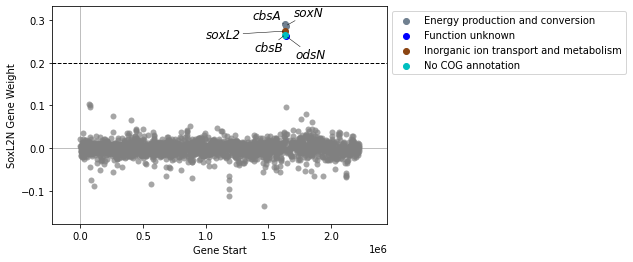

In [6]:
plot_gene_weights(ica_data, 'SoxL2N')

<AxesSubplot:xlabel='SoxL2N'>

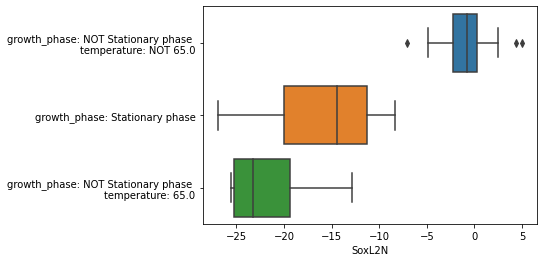

In [7]:
metadata_boxplot(ica_data, 'SoxL2N')

In [8]:
ica_data.view_imodulon('SoxL2N')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,refseq,regulator
SACI_RS08925,0.289731,cbsA,Saci_1858,Sacid_01828,NaN,1633061.0,1634449.0,+,cytochrome b558/566 subunit A,hypothetical protein,Energy production and conversion,A0A0U3GMR5,NC_007181.1,NaN
SACI_RS08930,0.266023,cbsB,Saci_1859,Sacid_01829,NaN,1634446.0,1635378.0,+,cytochrome b558/566 subunit B,hypothetical protein,No COG annotation,A0A0U3FC13,NC_007181.1,NaN
SACI_RS08935,0.274232,soxL2,Saci_1860,Sacid_01830,NaN,1635417.0,1636394.0,+,Rieske iron-sulfur protein SoxL2,hypothetical protein,Inorganic ion transport and metabolism,A0A0U3GPQ9,NC_007181.1,NaN
SACI_RS08940,0.286235,soxN,Saci_1861,Sacid_01831,petB_1,1636440.0,1638038.0,+,cytochrome bc complex cytochrome b subunit SoxN,Cytochrome b6,Energy production and conversion,A0A0U3GR09,NC_007181.1,NaN
SACI_RS08945,0.262889,odsN,Saci_1862,Sacid_01832,NaN,1638022.0,1638354.0,+,antibiotic biosynthesis monooxygenase,hypothetical protein,Function unknown,UPI0002B26481,NC_007181.1,NaN


<AxesSubplot:ylabel='SoxL2N iModulon\nActivity'>

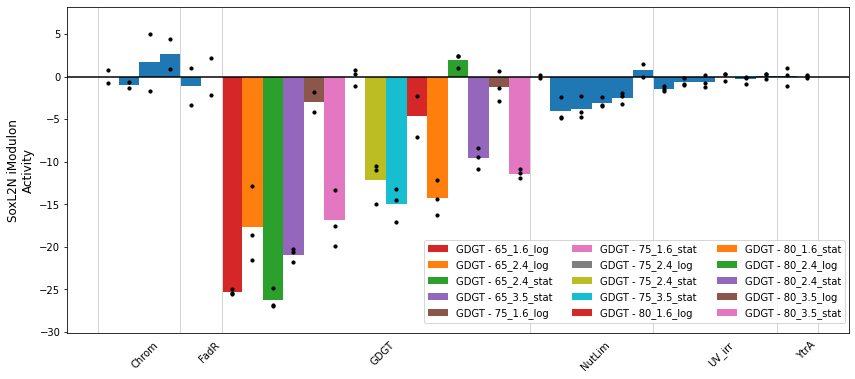

In [9]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'SoxL2N', highlight=['GDGT'], ax=ax,
                legend_kwargs={'bbox_to_anchor': (0.45, 0.3)})

### iModulon 18: UV-tfb3 iModulon

### Contains ced and ups sytems
### Contains tfb3 and her_A (Saci_0667, a DNA helicase)
### In addition, contains 5 un-named genes that may represent a potential DNA export system!

In [10]:
ica_data.rename_imodulons({18: 'UV-tfb3'})

<AxesSubplot:xlabel='Gene Start', ylabel='UV-tfb3 Gene Weight'>

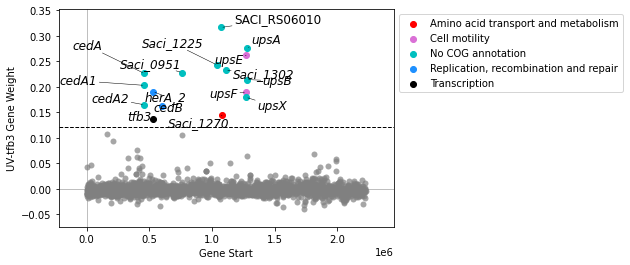

In [11]:
plot_gene_weights(ica_data, 'UV-tfb3')

#plt.savefig('../figures/tfb3_gene_weights.svg')

In [12]:
ica_data.view_imodulon('UV-tfb3')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,refseq,regulator
SACI_RS11810,0.164617,cedA2,Saci_0567,Sacid_00553,NaN,460159.0,460317.0,-,DNA import protein CedA2,hypothetical protein,No COG annotation,UPI00005522F4,NC_007181.1,NaN
SACI_RS02695,0.226076,cedA,Saci_0568,Sacid_00554,NaN,460333.0,461115.0,-,DNA import protein CedA,hypothetical protein,No COG annotation,A0A0U3GG40,NC_007181.1,NaN
SACI_RS02700,0.202697,cedA1,Saci_0569,Sacid_00555,NaN,461116.0,461352.0,-,DNA import protein CedA1,hypothetical protein,No COG annotation,A0A0U3GT29,NC_007181.1,NaN
SACI_RS03170,0.135878,tfb3,Saci_0665,Sacid_00647,NaN,526865.0,527452.0,+,TFIIB-type zinc ribbon-containing protein,hypothetical protein,Transcription,A0A0U3FEZ6,NC_007181.1,NaN
SACI_RS03180,0.190563,herA_2,Saci_0667,Sacid_00649,NaN,529180.0,530820.0,-,"HerA helicase, ATP-binding protein (VirB4/HerA...",hypothetical protein,"Replication, recombination and repair",A0A0U3GSV6,NC_007181.1,NaN
SACI_RS03575,0.162646,cedB,Saci_0748,Sacid_00730,NaN,597891.0,599684.0,+,DNA import protein CedB (ATP-binding),hypothetical protein,"Replication, recombination and repair",A0A0U3GTT0,NC_007181.1,NaN
SACI_RS04540,0.227926,Saci_0951,Saci_0951,Sacid_00927,NaN,760719.0,761144.0,-,hypothetical protein,hypothetical protein,No COG annotation,A0A0U3H1M8,NC_007181.1,NaN
SACI_RS05840,0.242446,Saci_1225,Saci_1225,Sacid_01202,NaN,1042172.0,1042501.0,+,hypothetical protein,hypothetical protein,No COG annotation,A0A0U3F641,NC_007181.1,NaN
SACI_RS06010,0.316290,SACI_RS06010,NaN,Sacid_01236,NaN,1071231.0,1071434.0,+,hypothetical protein,hypothetical protein,No COG annotation,A0A0U2N8L9,NC_007181.1,NaN
SACI_RS06065,0.143969,Saci_1270,Saci_1270,Sacid_01247,NaN,1080419.0,1081312.0,+,MFS family permease,hypothetical protein,Amino acid transport and metabolism,A0A0U3HJZ7,NC_007181.1,NaN


<AxesSubplot:ylabel='UV-tfb3 iModulon\nActivity'>

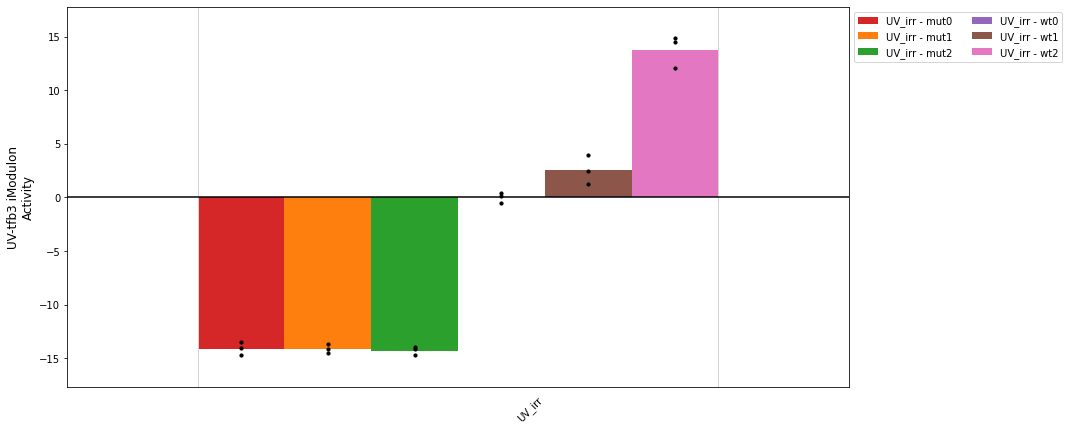

In [13]:
fig, ax = plt.subplots(figsize=(14, 7))

plot_activities(ica_data, 'UV-tfb3',projects='UV_irr', highlight='UV_irr', ax=ax)

#plt.savefig('../figures/tfb3_actv.svg')

### iModulon 34: Replication/Cell-Division iModulon

Contains:
* segA
* segB
* cdc6-1
* cdvA
* cdvB
* cdvC
* cdvB1
* cdvB2

In [14]:
ica_data.rename_imodulons({34: 'Replication'})

<AxesSubplot:xlabel='Gene Start', ylabel='Replication Gene Weight'>

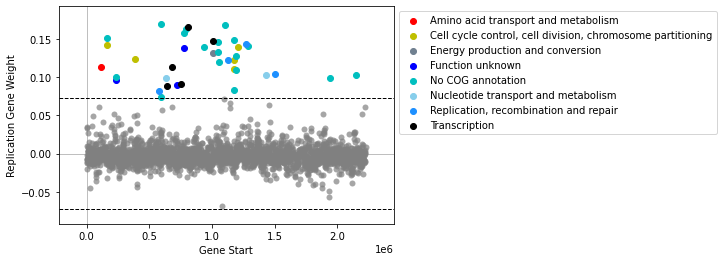

In [15]:
plot_gene_weights(ica_data, 'Replication')

In [16]:
ica_data.view_imodulon('Replication')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,refseq,regulator
SACI_RS00685,0.112974,Saci_0144,Saci_0144,Sacid_00139,NaN,113681.0,114820.0,+,MFS transporter,hypothetical protein,Amino acid transport and metabolism,A0A0U3FGK7,NC_007181.1,NaN
SACI_RS00980,0.151865,segB,Saci_0203,Sacid_00197,NaN,165123.0,165578.0,-,hypothetical protein,hypothetical protein,No COG annotation,A0A0U3FWP0,NC_007181.1,NaN
SACI_RS00985,0.142533,segA,Saci_0204,Sacid_00198,"parA, soj",165575.0,166237.0,-,ATPase involved in chromosome partitioning Par...,Sporulation initiation inhibitor protein Soj,"Cell cycle control, cell division, chromosome ...",A0A0U2NFX3,NC_007181.1,NaN
SACI_RS01345,0.099603,Saci_0276,Saci_0276,Sacid_00272,NaN,233183.0,233515.0,+,hypothetical protein,hypothetical protein,No COG annotation,UPI0002B28E20,NC_007181.1,NaN
SACI_RS01350,0.095981,Saci_0277,Saci_0277,Sacid_00273,NaN,233532.0,234461.0,+,MBL fold metallo-hydrolase,hypothetical protein,Function unknown,A0A0U3FFT6,NC_007181.1,NaN
SACI_RS02185,0.123250,cdvB1,Saci_0451,Sacid_00445,NaN,383513.0,384157.0,-,Cell division protein B1,hypothetical protein,"Cell cycle control, cell division, chromosome ...",UPI0000552296,NC_007181.1,NaN
SACI_RS03440,0.081789,cdc6-1,Saci_0722,Sacid_00700,NaN,578164.0,579357.0,-,ORC1-type DNA replication protein 1 (AAA famil...,hypothetical protein,"Replication, recombination and repair",A0A0U2Y835,NC_007181.1,NaN
SACI_RS03550,0.168987,Saci_0743,Saci_0743,Sacid_00725,NaN,594856.0,595146.0,+,hypothetical protein,hypothetical protein,No COG annotation,A0A0U3GVB9,NC_007181.1,NaN
SACI_RS03555,0.074320,Saci_0744,Saci_0744,Sacid_00726,NaN,595153.0,596007.0,+,NAD(P)/FAD-dependent oxidoreductase,hypothetical protein,No COG annotation,A0A0U3HL99,NC_007181.1,NaN
SACI_RS03775,0.098866,dcd,Saci_0789,Sacid_00769,dcd_1,632052.0,632570.0,+,dCTP deaminase,"dCTP deaminase, dUMP-forming",Nucleotide transport and metabolism,A0A0U2Y048,NC_007181.1,NaN


<AxesSubplot:ylabel='Replication iModulon\nActivity'>

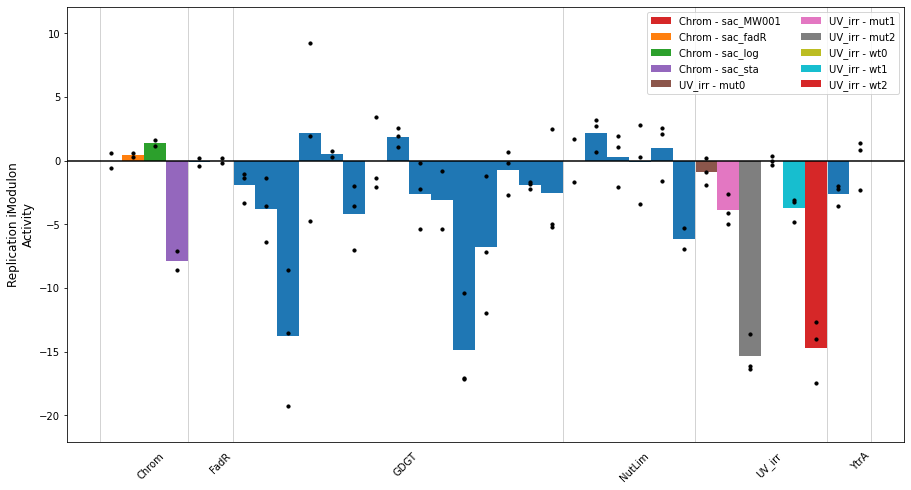

In [17]:
fig, ax = plt.subplots(figsize=(15, 8))

plot_activities(ica_data, 'Replication', highlight=['Chrom','UV_irr'], ax=ax)

### iModulon 35: Putative translation/RpoN iModulon

In [18]:
ica_data.rename_imodulons({35: 'translation-related'})

<AxesSubplot:xlabel='Gene Start', ylabel='translation-related Gene Weight'>

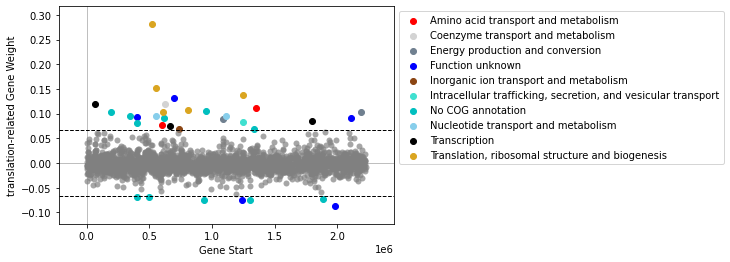

In [19]:
plot_gene_weights(ica_data, 'translation-related')

In [21]:
ica_data.view_imodulon('translation-related').sort_values(by='gene_weight', ascending=False)

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,refseq,regulator
SACI_RS03110,0.280566,Saci_0653,Saci_0653,Sacid_00635,NaN,517716.0,518114.0,-,tRNA methyltransferase,hypothetical protein,"Translation, ribosomal structure and biogenesis",A0A0U3GNB5,NC_007181.1,NaN
SACI_RS03315,0.151008,rpl24e,Saci_0697,NaN,NaN,556705.0,556893.0,-,50S ribosomal protein L24e,NaN,"Translation, ribosomal structure and biogenesis",A0A0U2N9E7,NC_007181.1,NaN
SACI_RS07005,0.137219,rpl39e,Saci_1467,Sacid_01434,"rl46, rpl46",1250546.0,1250707.0,-,50S ribosomal protein L39e,hypothetical protein,"Translation, ribosomal structure and biogenesis",UPI0000170023,NC_007181.1,NaN
SACI_RS11610,0.132598,Saci_0873,Saci_0873,Sacid_00851,NaN,700810.0,700977.0,-,YHS domain-containing protein,hypothetical protein,Function unknown,M1ITZ6,NC_007181.1,NaN
SACI_RS00405,0.120082,rpoN,Saci_0087,Sacid_00083,NaN,66004.0,66204.0,+,DNA-directed RNA polymerase subunit N,hypothetical protein,Transcription,A0A0U3H4H5,NC_007181.1,NaN
SACI_RS03740,0.119686,Saci_0781,Saci_0781,Sacid_00760,NaN,624041.0,624703.0,+,uroporphyrinogen-III synthase,hypothetical protein,Coenzyme transport and metabolism,A0A0U3GKS6,NC_007181.1,NaN
SACI_RS07535,0.110837,hisE,Saci_1580,Sacid_01545,NaN,1350433.0,1350720.0,+,phosphoribosyl-ATP diphosphatase,Phosphoribosyl-ATP pyrophosphatase,Amino acid transport and metabolism,A0A0U3H7U1,NC_007181.1,NaN
SACI_RS04820,0.106832,Saci_1010,Saci_1010,Sacid_00983,NaN,810474.0,810962.0,+,DUF1947 domain-containing protein,hypothetical protein,"Translation, ribosomal structure and biogenesis",A0A0U3GS18,NC_007181.1,NaN
SACI_RS11845,0.105876,SACI_RS11845,NaN,NaN,NaN,955170.0,955289.0,+,molybdopterin-dependent oxidoreductase,NaN,No COG annotation,UPI0002B27A63,NC_007181.1,NaN
SACI_RS11320,0.103074,ndhE,Saci_2340,Sacid_02340,NaN,2188490.0,2188774.0,-,NADH-quinone oxidoreductase subunit K,"NAD(P)H-quinone oxidoreductase subunit 4L, chl...",Energy production and conversion,A0A0U3GPW4,NC_007181.1,NaN


In [22]:
metadata_boxplot(ica_data, 'translation', n_boxes=2)

KeyError: 'translation'

<AxesSubplot:ylabel='translation-related iModulon\nActivity'>

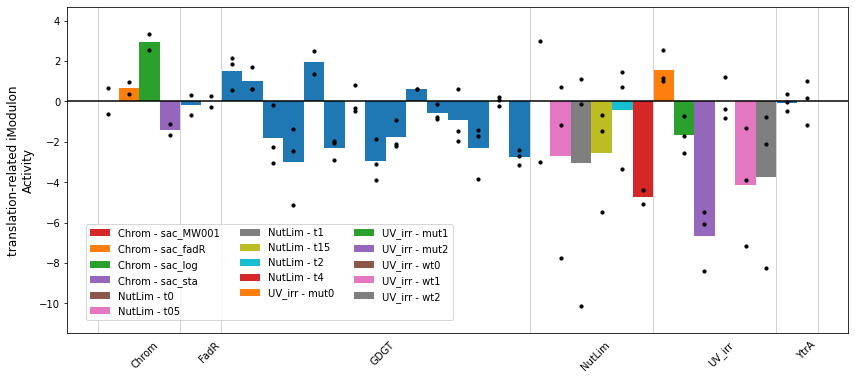

In [23]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'translation-related', highlight=['Chrom', 'NutLim', 'UV_irr'], ax=ax,
                legend_kwargs={'bbox_to_anchor':(0.5, 0.35)})

### iModulon 5: Niacin-transport iModulon
Consists of:

- Niacin/NAD(H) transporter
- D-xylose:proton symporter
- 2 hypothetical proteins
- Related to iModulon 31 (put. C/N fixation)

In [24]:
ica_data.rename_imodulons({5: 'niacin-transport'})

<AxesSubplot:xlabel='Gene Start', ylabel='niacin-transport Gene Weight'>

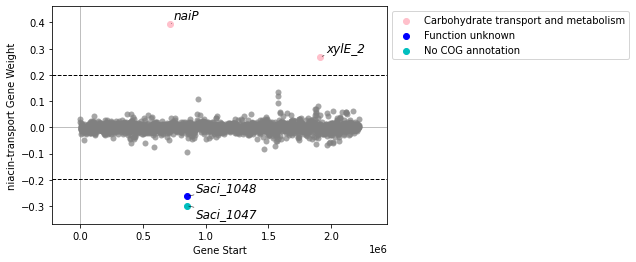

In [25]:
plot_gene_weights(ica_data, 'niacin-transport')

In [26]:
ica_data.view_imodulon('niacin-transport')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,refseq,regulator
SACI_RS04230,0.392167,naiP,Saci_0886,Sacid_00863,NaN,712521.0,714002.0,-,MFS transporter,Putative niacin/nicotinamide transporter NaiP,Carbohydrate transport and metabolism,A0A0U3HAF2,NC_007181.1,NaN
SACI_RS05000,-0.298456,Saci_1047,Saci_1047,Sacid_01021,NaN,848080.0,848499.0,-,hypothetical protein,hypothetical protein,No COG annotation,A0A0U3H1U4,NC_007181.1,NaN
SACI_RS05005,-0.262939,Saci_1048,Saci_1048,Sacid_01022,NaN,848599.0,848853.0,+,DUF504 domain-containing protein,hypothetical protein,Function unknown,A0A0U3H296,NC_007181.1,NaN
SACI_RS10120,0.268527,xylE_2,Saci_2095,Sacid_02091,NaN,1912263.0,1913636.0,-,MFS transporter,D-xylose-proton symporter,Carbohydrate transport and metabolism,A0A0U3GM32,NC_007181.1,NaN


<AxesSubplot:ylabel='niacin-transport iModulon\nActivity'>

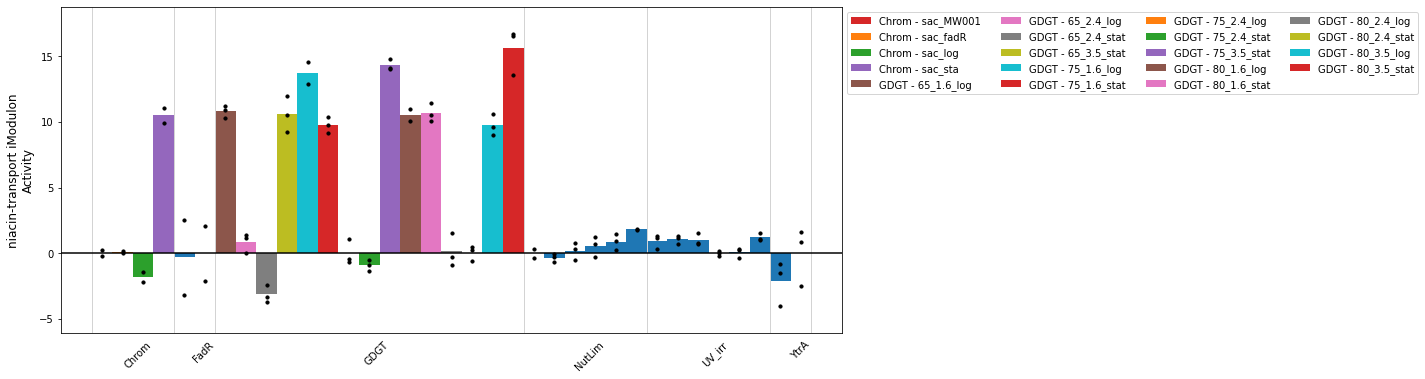

In [27]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'niacin-transport', highlight=['Chrom', 'GDGT'], ax=ax)

### iModulon 41: Thiamin (Vit B1) iModulon (Potentially Heavy-Metal related)

In [28]:
ica_data.rename_imodulons({41: 'Thiamin'})

<AxesSubplot:xlabel='Gene Start', ylabel='Thiamin Gene Weight'>

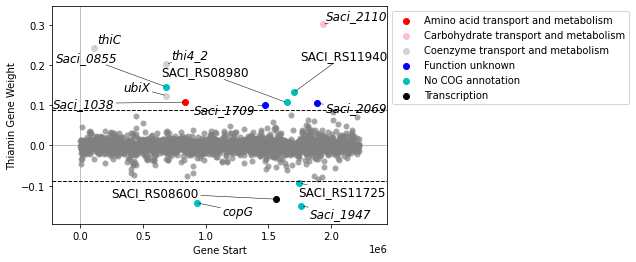

In [29]:
plot_gene_weights(ica_data, 'Thiamin')

In [30]:
ica_data.view_imodulon('Thiamin').sort_values(by='gene_weight', ascending=False)

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,refseq,regulator
SACI_RS10200,0.300793,Saci_2110,Saci_2110,Sacid_02107,NaN,1931025.0,1932332.0,-,MFS transporter,hypothetical protein,Carbohydrate transport and metabolism,A0A0U3FXT5,NC_007181.1,NaN
SACI_RS00650,0.242554,thiC,Saci_0137,Sacid_00132,bzaF,107432.0,108718.0,+,phosphomethylpyrimidine synthase ThiC,5-hydroxybenzimidazole synthase,Coenzyme transport and metabolism,A0A0U2Y1Q4,NC_007181.1,NaN
SACI_RS04090,0.201410,thi4_2,Saci_0854,Sacid_00833,thi4,685342.0,686139.0,-,thiazole biosynthesis protein,Thiamine thiazole synthase,Coenzyme transport and metabolism,A0A0U2XZZ7,NC_007181.1,NaN
SACI_RS11600,0.145373,Saci_0855,Saci_0855,NaN,NaN,686222.0,686431.0,+,TRASH domain-containing protein,NaN,No COG annotation,UPI00005523E6,NC_007181.1,NaN
SACI_RS11940,0.131866,SACI_RS11940,NaN,NaN,NaN,1701777.0,1702049.0,+,hypothetical protein,NaN,No COG annotation,UPI0002B260AD,NC_007181.1,NaN
SACI_RS04095,0.123935,ubiX,Saci_0856,Sacid_00834,NaN,686362.0,687024.0,+,UbiX family flavin prenyltransferase,Flavin prenyltransferase UbiX,Coenzyme transport and metabolism,A0A0U2WZN2,NC_007181.1,NaN
SACI_RS04960,0.107777,Saci_1038,Saci_1038,Sacid_01012,NaN,836997.0,839600.0,-,ABC transporter substrate-binding protein,hypothetical protein,Amino acid transport and metabolism,A0A0U2NE45,NC_007181.1,NaN
SACI_RS08980,0.106838,SACI_RS08980,NaN,NaN,NaN,1644920.0,1645132.0,-,hypothetical protein,NaN,No COG annotation,A0A0U3H528,NC_007181.1,NaN
SACI_RS10005,0.104651,Saci_2069,Saci_2069,Sacid_02064,NaN,1887074.0,1887406.0,+,metal-sulfur cluster assembly factor,hypothetical protein,Function unknown,A0A0U3FYQ8,NC_007181.1,NaN
SACI_RS11700,0.100666,Saci_1709,Saci_1709,NaN,NaN,1468477.0,1468635.0,-,TRASH domain-containing protein,NaN,Function unknown,UPI00005526DC,NC_007181.1,NaN


In [31]:
ica_data.thresholds['Thiamin']

0.08859783933639284

In [32]:
ica_data.M.loc['SACI_RS11300', 'Thiamin']

-0.0088612953227928

### iModulon 33: Uncharacterized iModulon 4

In [33]:
ica_data.rename_imodulons({33: 'unchar-4'})

<AxesSubplot:xlabel='Gene Start', ylabel='unchar-4 Gene Weight'>

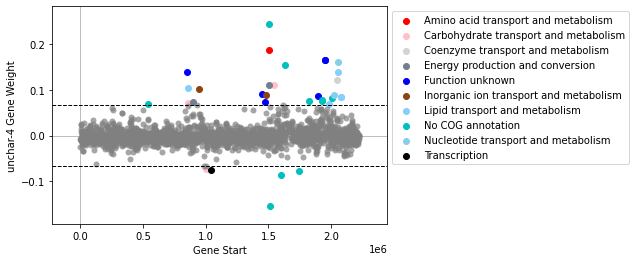

In [34]:
plot_gene_weights(ica_data, 'unchar-4')

In [35]:
ica_data.view_imodulon('unchar-4')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,refseq,regulator
SACI_RS03235,0.069043,Saci_0680,Saci_0680,Sacid_00661,NaN,540470.0,541363.0,-,hypothetical protein,hypothetical protein,No COG annotation,A0A0U3GK13,NC_007181.1,NaN
SACI_RS05025,0.139720,Saci_1052,Saci_1052,Sacid_01026,NaN,853736.0,854056.0,+,GYD domain-containing protein,Glutamine synthetase and cystathionine beta-ly...,Function unknown,A0A0U2VU45,NC_007181.1,NaN
SACI_RS05035,0.102884,Saci_1054,Saci_1054,Sacid_01028,NaN,855397.0,857076.0,+,long-chain-fatty-acid--CoA ligase,Long-chain-fatty-acid--CoA ligase,Lipid transport and metabolism,UPI0002B29646,NC_007181.1,NaN
SACI_RS05050,0.070690,glpK_3,Saci_1058,Sacid_01033,NaN,860143.0,861657.0,-,FGGY-family carbohydrate kinase,Glycerol kinase,Carbohydrate transport and metabolism,A0A0U3H185,NC_007181.1,NaN
SACI_RS05235,0.072807,gbsA,Saci_1099,Sacid_01075,NaN,897628.0,899109.0,+,aldehyde dehydrogenase,Betaine aldehyde dehydrogenase,Energy production and conversion,A0A0U3H157,NC_007181.1,NaN
SACI_RS05415,0.102230,ydjE_1,Saci_1136,Sacid_01111,NaN,944847.0,946262.0,+,MFS transporter,Inner membrane metabolite transport protein YdjE,Inorganic ion transport and metabolism,A0A0U3H243,NC_007181.1,NaN
SACI_RS05635,-0.073493,stp,Saci_1182,Sacid_01159,NaN,998087.0,999520.0,-,"MFS permease, MFS transporter",Multidrug resistance protein Stp,Carbohydrate transport and metabolism,A0A0U3H154,NC_007181.1,NaN
SACI_RS05830,-0.075014,abfR2,Saci_1223,Sacid_01200,NaN,1041456.0,1041827.0,+,Lrs14 family biofilm regulator AbfR2,hypothetical protein,Transcription,A0A0U3FE21,NC_007181.1,NaN
SACI_RS08080,0.091552,Saci_1692,Saci_1692,Sacid_01656,NaN,1450416.0,1450697.0,+,cation transporter,hypothetical protein,Function unknown,A0A0U3H5I8,NC_007181.1,NaN
SACI_RS08185,0.072719,thpS,Saci_1714,Sacid_01677,NaN,1473212.0,1474234.0,-,thermopsin,hypothetical protein,Function unknown,A0A0U3H5H2,NC_007181.1,NaN


<AxesSubplot:ylabel='unchar-4 iModulon\nActivity'>

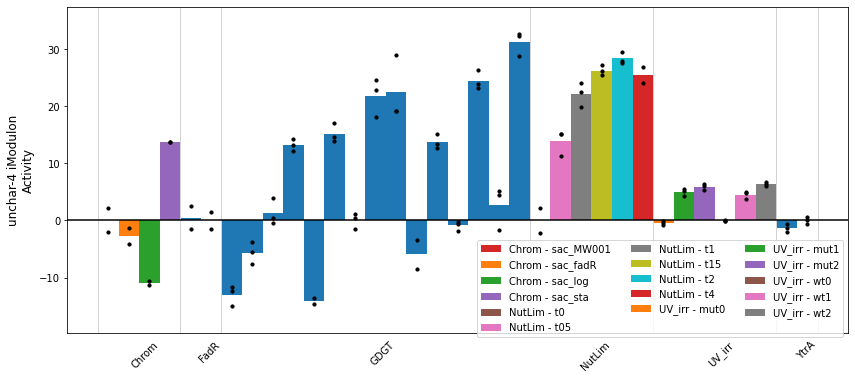

In [36]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'unchar-4', highlight=['Chrom', 'NutLim', 'UV_irr'], ax=ax,
                legend_kwargs={'bbox_to_anchor':(1, 0.3)})

### iModulon 32: Uncharacterized iModulon 3 (UV-related)

In [37]:
ica_data.rename_imodulons({32: 'unchar-3'})

<AxesSubplot:xlabel='Gene Start', ylabel='unchar-3 Gene Weight'>

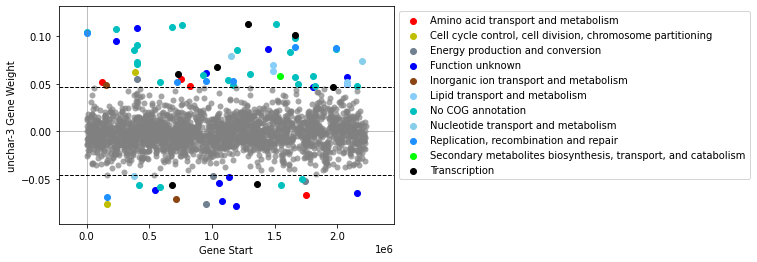

In [38]:
plot_gene_weights(ica_data, 'unchar-3')

In [39]:
# Uncomment below to see genes enriched in this iModulon

#ica_data.view_imodulon(32)[0:40]
#ica_data.view_imodulon(32)[40:]

<AxesSubplot:ylabel='unchar-3 iModulon\nActivity'>

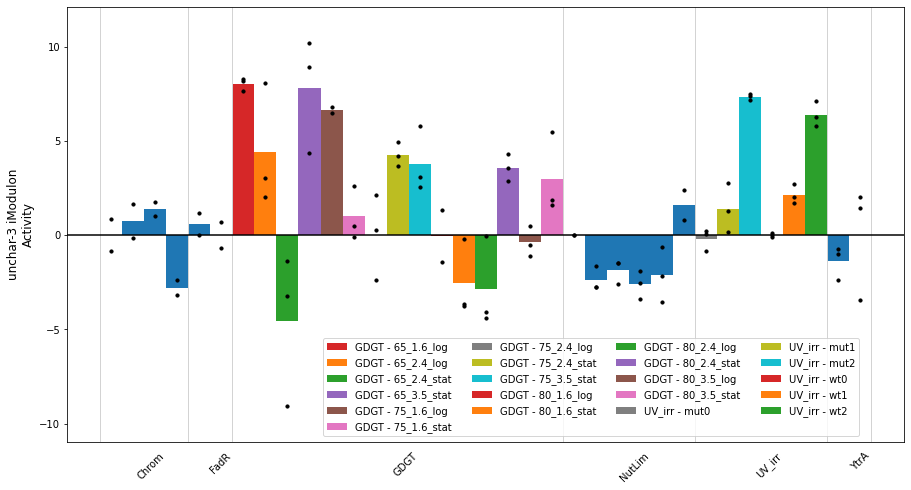

In [40]:
fig, ax = plt.subplots(figsize=(15, 8))

plot_activities(ica_data, 'unchar-3', highlight=['GDGT', 'UV_irr'], ax=ax,
                legend_kwargs={'bbox_to_anchor':(0.3, 0.25)})

### iModulon 38: Putative Ammonium Uptake iModulon [E coli Ortholog: NtrC+RpoN]
### Probable Nitrogen Metabolism Involvement

In [41]:
ica_data.rename_imodulons({38: 'Ammonium-Uptake'})

<AxesSubplot:xlabel='Gene Start', ylabel='Ammonium-Uptake Gene Weight'>

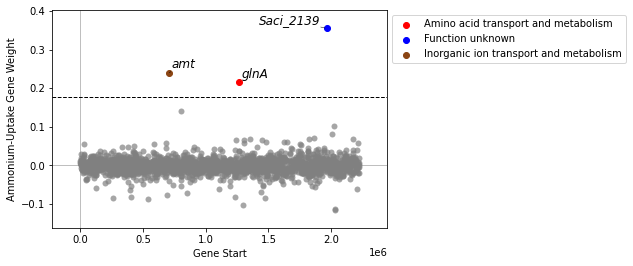

In [42]:
plot_gene_weights(ica_data, 'Ammonium-Uptake')

In [43]:
ica_data.view_imodulon('Ammonium-Uptake')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,refseq,regulator
SACI_RS04215,0.240628,amt,Saci_0883,Sacid_00860,NaN,708849.0,710294.0,+,"Ammonia permease, ammonium transporter",Ammonia channel,Inorganic ion transport and metabolism,UPI0002B27354,NC_007181.1,XylR
SACI_RS07075,0.215236,glnA,Saci_1483,Sacid_01450,glnA_1,1261179.0,1262600.0,-,type I glutamate--ammonia ligase,Glutamine synthetase,Amino acid transport and metabolism,A0A0U2WW46,NC_007181.1,LrpC
SACI_RS10345,0.354988,Saci_2139,Saci_2139,Sacid_02137,NaN,1966994.0,1967353.0,-,hypothetical protein,hypothetical protein,Function unknown,A0A0U3FQV9,NC_007181.1,XylR


<AxesSubplot:ylabel='Ammonium-Uptake iModulon\nActivity'>

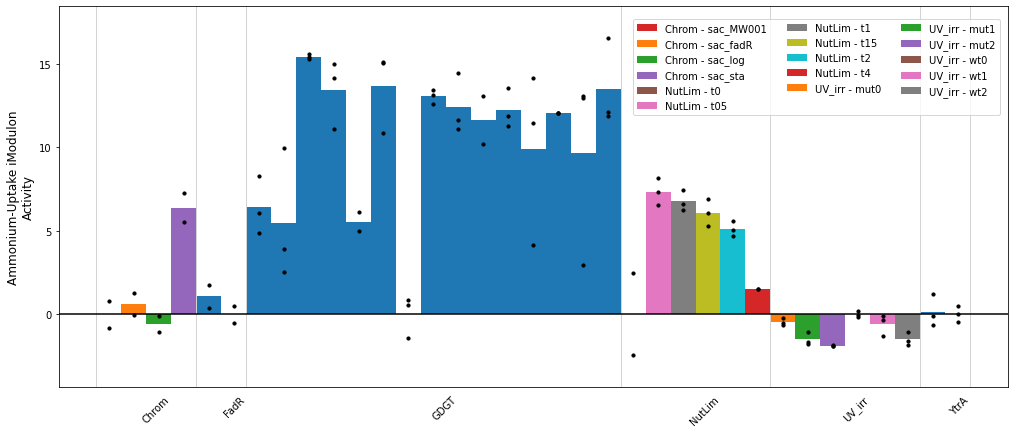

In [44]:
# Very messy activities with GDGT
fig, ax = plt.subplots(figsize=(17, 7))

plot_activities(ica_data, 'Ammonium-Uptake', highlight=['Chrom', 'NutLim', 'UV_irr'], ax=ax,
                legend_kwargs={'bbox_to_anchor':(0.6, 0.7)})

### iModulon 14: Phenylacetate Degradation iModulon

In [45]:
ica_data.rename_imodulons({14: 'Phenylacetate'})

<AxesSubplot:xlabel='Gene Start', ylabel='Phenylacetate Gene Weight'>

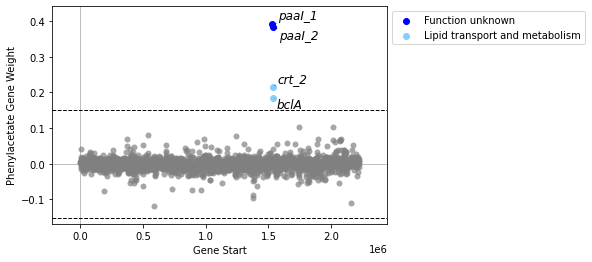

In [46]:
plot_gene_weights(ica_data, 'Phenylacetate')

In [47]:
ica_data.view_imodulon('Phenylacetate')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,refseq,regulator
SACI_RS08465,0.390392,paaI_1,Saci_1770,Sacid_01736,paaI,1531395.0,1532090.0,-,phenylacetate-CoA oxygenase subunit PaaI,hypothetical protein,Function unknown,A0A0U3H790,NC_007181.1,NaN
SACI_RS08470,0.382446,paaI_2,Saci_1771,Sacid_01737,"paaI, boxB",1532100.0,1532870.0,-,phenylacetate-CoA oxygenase subunit PaaI,Benzoyl-CoA oxygenase component B,Function unknown,A0A0U3FSM1,NC_007181.1,NaN
SACI_RS08475,0.215781,crt_2,Saci_1772,Sacid_01738,NaN,1533033.0,1533836.0,+,enoyl-CoA hydratase/isomerase family protein,Short-chain-enoyl-CoA hydratase,Lipid transport and metabolism,A0A0U3GMZ0,NC_007181.1,NaN
SACI_RS08485,0.184597,bclA,Saci_1774,Sacid_01740,NaN,1535691.0,1537271.0,+,benzoate-CoA ligase family protein,Benzoate--CoA ligase,Lipid transport and metabolism,A0A0U3HIU5,NC_007181.1,NaN


<AxesSubplot:ylabel='Phenylacetate iModulon\nActivity'>

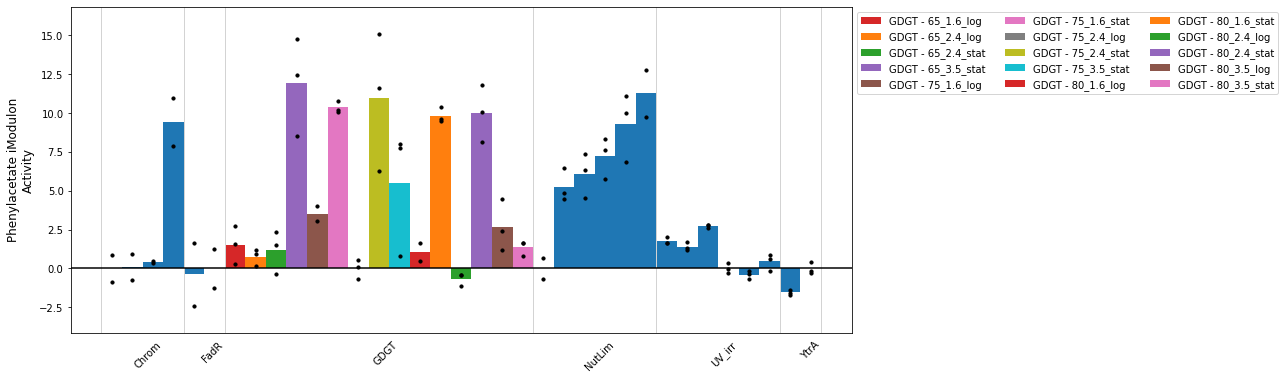

In [48]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'Phenylacetate', highlight='GDGT', ax=ax)

<AxesSubplot:ylabel='Phenylacetate iModulon\nActivity'>

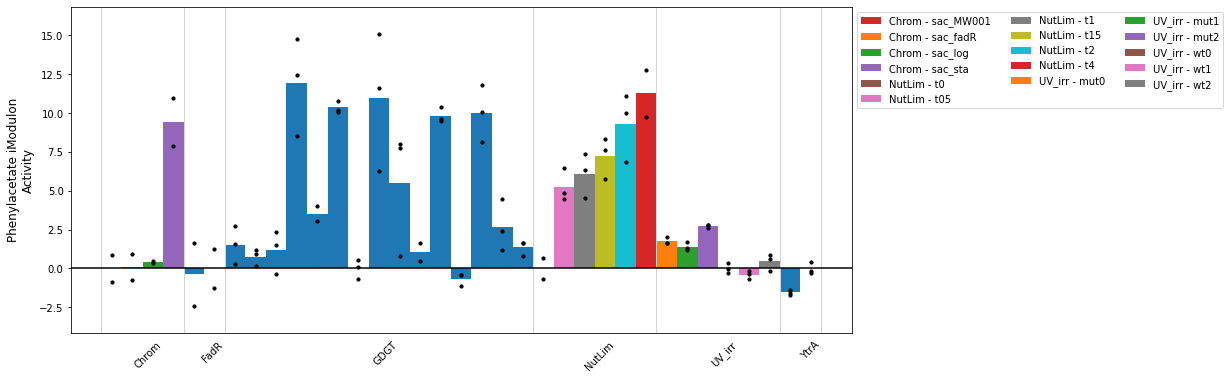

In [49]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'Phenylacetate', highlight=['Chrom', 'NutLim', 'UV_irr'], ax=ax)

### iModulon 8: Iron-Sulfur-Lipoylation-Associated iModulon

Many iron-sulfur related genes

Many lipoylation/acyl-lipid-carrier proteins

In [50]:
ica_data.rename_imodulons({8: 'Fe-S-lipoylation-gene-cluster'})

<AxesSubplot:xlabel='Gene Start', ylabel='Fe-S-lipoylation-gene-cluster Gene Weight'>

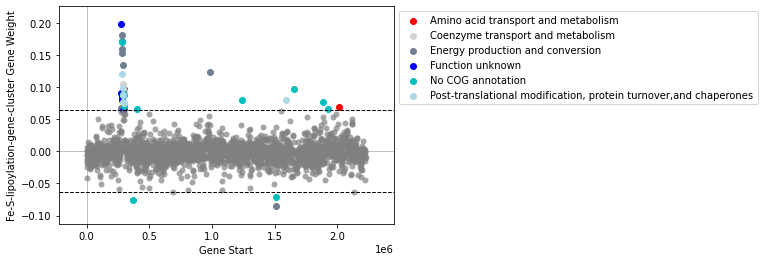

In [51]:
plot_gene_weights(ica_data, 'Fe-S-lipoylation-gene-cluster')

In [52]:
ica_data.view_imodulon('Fe-S-lipoylation-gene-cluster')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,refseq,regulator
SACI_RS01565,0.068132,fdhF,Saci_0320,Sacid_00316,NaN,272254.0,275184.0,-,formate dehydrogenase subunit alpha,Putative formate dehydrogenase,Energy production and conversion,A0A0U2Y905,NC_007181.1,NaN
SACI_RS01570,0.090674,Saci_0321,Saci_0321,Sacid_00317,NaN,275396.0,276538.0,-,2'-5' RNA ligase family protein,hypothetical protein,Function unknown,A0A0U3H3W5,NC_007181.1,NaN
SACI_RS01585,0.197796,Saci_0324,Saci_0324,Sacid_00320,NaN,277460.0,278311.0,-,sulfite exporter TauE/SafE family protein,putative membrane transporter protein,Function unknown,A0A0U2VW32,NC_007181.1,NaN
SACI_RS01590,0.153582,sdhE_1,Saci_0325,Sacid_00321,NaN,278371.0,279282.0,-,CoB--CoM heterodisulfide reductase iron-sulfur...,8-methylmenaquinol:fumarate reductase membrane...,Energy production and conversion,A0A0U3FPF4,NC_007181.1,NaN
SACI_RS01595,0.158831,Saci_0326,Saci_0326,Sacid_00322,NaN,279279.0,279971.0,-,4Fe-4S dicluster domain-containing protein,hypothetical protein,Energy production and conversion,A0A0U2WT74,NC_007181.1,NaN
SACI_RS01600,0.170436,Saci_0327,Saci_0327,Sacid_00323,NaN,279958.0,280641.0,-,"Heterodisulfide reductase, subunit A, polyferr...",hypothetical protein,No COG annotation,A0A0U2Y162,NC_007181.1,XylR
SACI_RS01605,0.180646,thi4_1,Saci_0328,Sacid_00324,NaN,280685.0,281782.0,-,CoB--CoM heterodisulfide reductase iron-sulfur...,Thiamine thiazole synthase,Energy production and conversion,A0A0U3GTK9,NC_007181.1,NaN
SACI_RS01610,0.172489,Saci_0329,Saci_0329,Sacid_00325,NaN,281837.0,283147.0,-,heterodisulfide reductase subunit B,hypothetical protein,Energy production and conversion,A0A0U3GUQ8,NC_007181.1,NaN
SACI_RS01615,0.119824,Saci_0330,Saci_0330,Sacid_00326,NaN,283670.0,283903.0,+,sulfurtransferase TusA family protein,hypothetical protein,"Post-translational modification, protein turno...",A0A0U3FNF5,NC_007181.1,NaN
SACI_RS01620,0.085121,Saci_0331,Saci_0331,Sacid_00327,NaN,283916.0,285073.0,+,NAD(P)/FAD-dependent oxidoreductase,hypothetical protein,Function unknown,A0A0U3H3H3,NC_007181.1,NaN


<AxesSubplot:ylabel='Fe-S-lipoylation-gene-cluster iModulon\nActivity'>

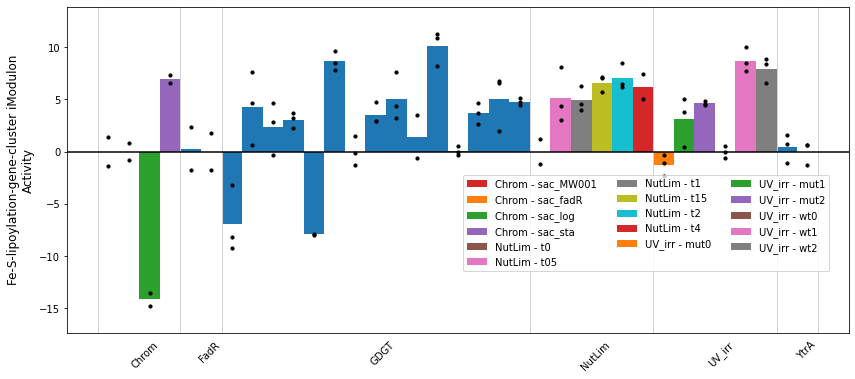

In [53]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'Fe-S-lipoylation-gene-cluster', highlight=['Chrom', 'NutLim', 'UV_irr'], ax=ax,
                legend_kwargs={'bbox_to_anchor': (0.5, 0.5)})

### iModulon 3: Long-Chain Fatty-Acid iModulon

* Contains Saci_2137, a known gene regulated by Saci_2136 (barR)
* Potentially regulated by BarR or BarR-like TF

In [54]:
ica_data.rename_imodulons({3: 'long-chain-fatty-acid'})

<AxesSubplot:xlabel='Gene Start', ylabel='long-chain-fatty-acid Gene Weight'>

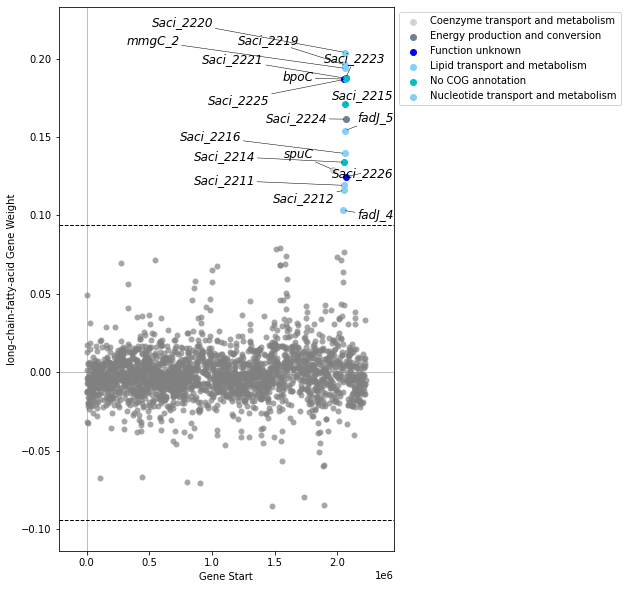

In [55]:
fig, ax = plt.subplots(figsize=(6, 10))

plot_gene_weights(ica_data, 'long-chain-fatty-acid', ax=ax)

In [56]:
ica_data.view_imodulon('long-chain-fatty-acid')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,refseq,regulator
SACI_RS10335,0.129288,spuC,Saci_2137,Sacid_02135,NaN,1964516.0,1965850.0,+,beta-alanine aminotransferase,Putrescine--pyruvate aminotransferase,Coenzyme transport and metabolism,A0A0U3HCW1,NC_007181.1,BarR
SACI_RS10675,0.103259,fadJ_4,Saci_2208,Sacid_02209,NaN,2046825.0,2048798.0,-,3-hydroxyacyl-CoA dehydrogenase/enoyl-CoA hydr...,Fatty acid oxidation complex subunit alpha,Lipid transport and metabolism,A0A0U3FHD7,NC_007181.1,NaN
SACI_RS10690,0.119224,Saci_2211,Saci_2211,Sacid_02212,NaN,2050681.0,2052348.0,-,long-chain-fatty-acid--CoA ligase,Long-chain-fatty-acid--CoA ligase,Lipid transport and metabolism,A0A0U3GLS7,NC_007181.1,NaN
SACI_RS10695,0.116022,Saci_2212,Saci_2212,Sacid_02213,NaN,2052558.0,2053550.0,+,R2-like ligand-binding oxidase,hypothetical protein,Nucleotide transport and metabolism,A0A0U3GN22,NC_007181.1,NaN
SACI_RS10700,0.186997,bpoC,Saci_2213,Sacid_02214,NaN,2053621.0,2054565.0,-,alpha/beta hydrolase,Putative non-heme bromoperoxidase BpoC,Function unknown,F2Z668,NC_007181.1,NaN
SACI_RS10705,0.133943,Saci_2214,Saci_2214,Sacid_02215,NaN,2054663.0,2056171.0,-,hypothetical protein,hypothetical protein,No COG annotation,A0A0U3GXE1,NC_007181.1,NaN
SACI_RS10710,0.170888,Saci_2215,Saci_2215,Sacid_02216,NaN,2056355.0,2058994.0,-,hypothetical protein,hypothetical protein,No COG annotation,A0A0U3GHV8,NC_007181.1,NaN
SACI_RS10715,0.139543,Saci_2216,Saci_2216,Sacid_02217,NaN,2059230.0,2059847.0,-,hypothetical protein,hypothetical protein,Lipid transport and metabolism,A0A0U2VXF7,NC_007181.1,NaN
SACI_RS10720,0.193837,mmgC_2,Saci_2217,Sacid_02219,NaN,2059997.0,2061196.0,+,acyl-CoA dehydrogenase family protein,Acyl-CoA dehydrogenase,Lipid transport and metabolism,A0A0U3FQM0,NC_007181.1,NaN
SACI_RS10725,0.154157,fadJ_5,Saci_2218,Sacid_02220,NaN,2061332.0,2063251.0,+,3-hydroxyacyl-CoA dehydrogenase/enoyl-CoA hydr...,Fatty acid oxidation complex subunit alpha,Lipid transport and metabolism,A0A0U3FYV7,NC_007181.1,NaN


<AxesSubplot:xlabel='long-chain-fatty-acid'>

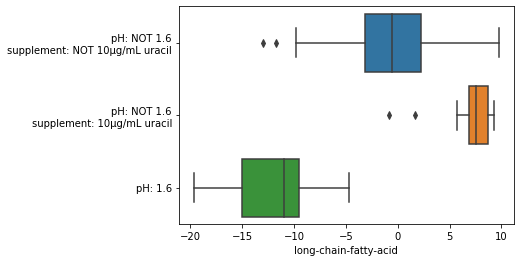

In [57]:
metadata_boxplot(ica_data, 'long-chain-fatty-acid')

<AxesSubplot:ylabel='long-chain-fatty-acid iModulon\nActivity'>

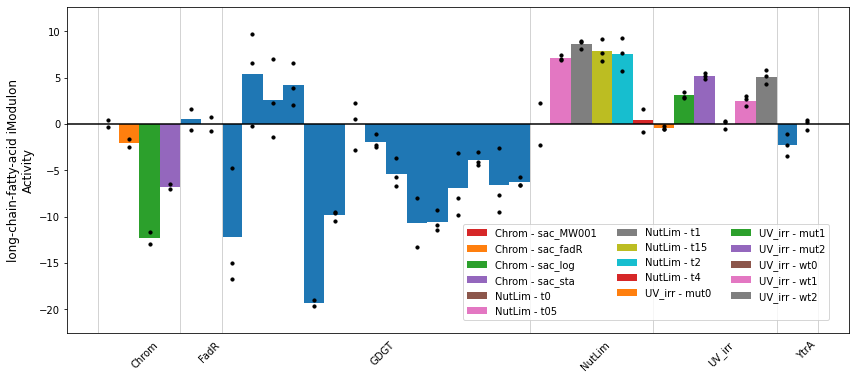

In [58]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'long-chain-fatty-acid', highlight=['Chrom', 'NutLim', 'UV_irr'], ax=ax,
                legend_kwargs={'bbox_to_anchor':(0.5, 0.35)})

<AxesSubplot:ylabel='long-chain-fatty-acid iModulon\nActivity'>

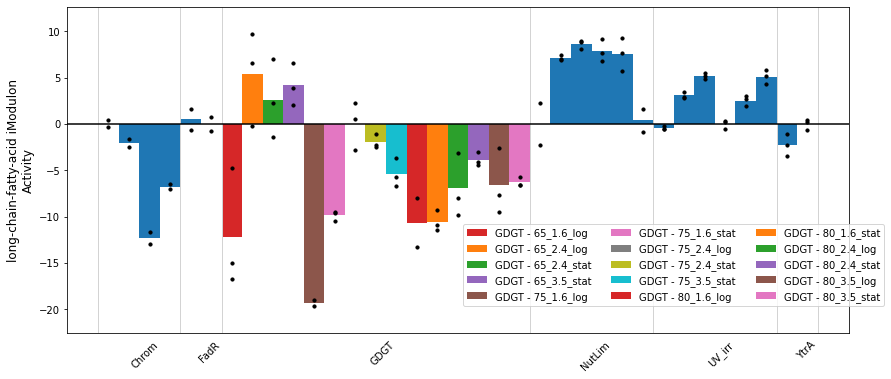

In [59]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'long-chain-fatty-acid', highlight=['GDGT'], ax=ax,
                legend_kwargs={'bbox_to_anchor':(0.5, 0.35)})

### iModulon 0: pseudogene iModulon

* According to Biocyc SACI_RS05165 is a frame-shifted pseudogene

In [ ]:
ica_data.rename_imodulons({0: 'pseudogene'})

In [ ]:
plot_gene_weights(ica_data, 'pseudogene')

In [ ]:
ica_data.view_imodulon('pseudogene')

# SACI_RS08610 is a framshifted pseudogene (biocyc)

In [ ]:
# Plots below show something odd going on with 75 C, 2.4 pH, stationary phase condition
metadata_boxplot(ica_data, 'pseudogene')

In [ ]:
# 75 C, 3.5 pH, stationary phase & 80 C, 3.5 pH, stationary phase also show some odd activity
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'pseudogene', highlight='GDGT', ax=ax)

### iModulon 1: heat-stress iModulon (different from heat-shock)

In [ ]:
ica_data.rename_imodulons({1: 'heat-stress'})

In [ ]:
plot_gene_weights(ica_data, 'heat-stress')

In [ ]:
metadata_boxplot(ica_data, 'heat-stress', n_boxes=2)

In [ ]:
ica_data.view_imodulon('heat-stress')

In [ ]:
fig, ax = plt.subplots(figsize=(15, 7))

plot_activities(ica_data, 'heat-stress', highlight='GDGT', ax=ax,
                legend_kwargs={'bbox_to_anchor':(0.49, 1)})

### iModulon 6: cold-stress iModulon

In [ ]:
ica_data.rename_imodulons({6: 'cold-stress'})

In [ ]:
plot_gene_weights(ica_data, 'cold-stress')

In [ ]:
metadata_boxplot(ica_data, 'cold-stress', n_boxes=2)

In [ ]:
ica_data.view_imodulon('cold-stress')

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'cold-stress', highlight=['GDGT', 'UV_irr'], ax=ax,
                legend_kwargs={'bbox_to_anchor':(0.3, 0.4)})

### iModulon 15: single_gene_1 (Uncharacterized iModulon)

In [ ]:
plot_gene_weights(ica_data, 'single_gene_1')

In [ ]:
ica_data.view_imodulon('single_gene_1')

### iModulon 16: single_gene_2 (Uncharacterized iModulon)

In [ ]:
plot_gene_weights(ica_data, 'single_gene_2')

In [ ]:
ica_data.view_imodulon('single_gene_2')

### iModulon 20: Hydtanoinase-acetophenone based iModulon

- Putative Nitrogen Starvation / Aromatic degradation / Antibiotic production iModulon

- Operon from Saci_2036 to Saci_2042 (excluding Saci_2040)

- Saci_2040 is a predicted TF [uniprot] and is missing from this operon (potential regulator of this operon?)

- https://pubmed.ncbi.nlm.nih.gov/29667297/

In [ ]:
ica_data.rename_imodulons({20: 'Glutathione'})

In [ ]:
plot_gene_weights(ica_data, 'Glutathione')

In [ ]:
ica_data.view_imodulon('Glutathione')

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'Glutathione', highlight=['NutLim'], ax=ax)

### iModulon 22: Uncharacterized iModulon 2

- 3 integrases and 1 PIN domain endonuclease
- Potentially from a virus?

In [ ]:
ica_data.rename_imodulons({22: 'unchar-2'})

In [ ]:
plot_gene_weights(ica_data, 'unchar-2')

In [ ]:
metadata_boxplot(ica_data, 'unchar-2', n_boxes=2)

In [ ]:
ica_data.view_imodulon('unchar-2')

### iModulon 28: single_gene_3 (Uncharacterized iModulon)

In [ ]:
ica_data.rename_imodulons({'single_gene_4': 'single_gene_3'})

In [ ]:
plot_gene_weights(ica_data, 'single_gene_3')

In [ ]:
ica_data.view_imodulon('single_gene_3')

### iModulon 30: Cytochrome reductase (SoxLABCD) iModulon

In [ ]:
ica_data.rename_imodulons({30: 'SoxLABCD'})

In [ ]:
plot_gene_weights(ica_data, 'SoxLABCD')

In [ ]:
ica_data.view_imodulon('SoxLABCD')

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'SoxLABCD', highlight=['NutLim'], ax=ax)

### iModulon 36: NAD(+) biosynthesis iModulon

- Putative Nicotine biosynthesis iModulon
- Putative Pyrmidine degradation iModulon

In [ ]:
ica_data.rename_imodulons({36: 'Quinolinate'})

In [ ]:
plot_gene_weights(ica_data, 'Quinolinate')

In [ ]:
ica_data.view_imodulon('Quinolinate')

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'Quinolinate', highlight=['NutLim'], ax=ax)

### iModulon 37: Aromatic Compound (degradation) related iModulon (Possibly  Napthalene degradation)

* Contains Saci_2137, a known gene regulated by Saci_2136 (barR)
* Potentially regulated by BarR or BarR-like TF

In [60]:
ica_data.rename_imodulons({37: 'aromatic-degradation'})

<AxesSubplot:xlabel='Gene Start', ylabel='aromatic-degradation Gene Weight'>

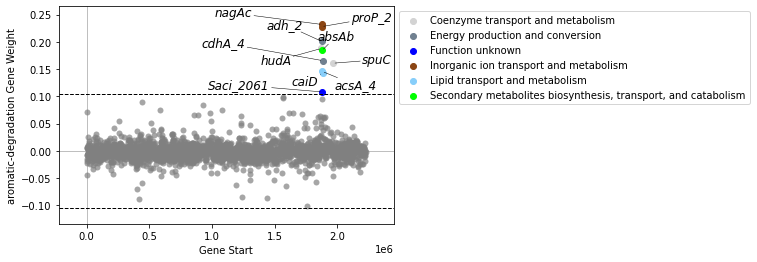

In [61]:
plot_gene_weights(ica_data, 'aromatic-degradation')

In [62]:
ica_data.view_imodulon('aromatic-degradation')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,refseq,regulator
SACI_RS09935,0.187770,hudA,Saci_2055,Sacid_02050,NaN,1871167.0,1872585.0,-,UbiD family decarboxylase,UbiD-like decarboxylase,Coenzyme transport and metabolism,A0A0U3HGB3,NC_007181.1,NaN
SACI_RS09945,0.200823,adh_2,Saci_2057,Sacid_02052,adh,1873919.0,1874953.0,-,NAD(P)-dependent alcohol dehydrogenase,Alcohol dehydrogenase,Energy production and conversion,A0A0U2NH16,NC_007181.1,YtrA
SACI_RS09950,0.227832,proP_2,Saci_2058,Sacid_02053,NaN,1875156.0,1876487.0,-,MFS transporter,Proline/betaine transporter,Inorganic ion transport and metabolism,A0A0U3GPF6,NC_007181.1,NaN
SACI_RS09955,0.231724,nagAc,Saci_2059,Sacid_02054,NaN,1876682.0,1878025.0,+,aromatic ring-hydroxylating dioxygenase subuni...,"Naphthalene 1,2-dioxygenase system, large oxyg...",Inorganic ion transport and metabolism,A0A0U3HNQ5,NC_007181.1,NaN
SACI_RS09960,0.184133,absAb,Saci_2060,Sacid_02055,NaN,1878019.0,1878531.0,+,aromatic ring dioxygenase subunit B,"2-aminobenzenesulfonate 2,3-dioxygenase subuni...","Secondary metabolites biosynthesis, transport,...",A0A0U3FQB8,NC_007181.1,NaN
SACI_RS09965,0.108108,Saci_2061,Saci_2061,Sacid_02056,NaN,1878613.0,1879272.0,+,helix-turn-helix domain-containing protein,hypothetical protein,Function unknown,A0A0U3H5B5,NC_007181.1,NaN
SACI_RS09970,0.145584,acsA_4,Saci_2062,Sacid_02057,NaN,1879438.0,1881123.0,+,acetyl-CoA synthetase,Acetyl-coenzyme A synthetase,Lipid transport and metabolism,A0A0U3GV35,NC_007181.1,NaN
SACI_RS09975,0.142399,caiD,Saci_2063,Sacid_02058,NaN,1881193.0,1881957.0,+,enoyl-CoA hydratase/isomerase family protein,Carnitinyl-CoA dehydratase,Lipid transport and metabolism,A0A0U3GW81,NC_007181.1,NaN
SACI_RS09980,0.165472,cdhA_4,Saci_2064,Sacid_02059,NaN,1881960.0,1884236.0,+,xanthine dehydrogenase family protein molybdop...,Caffeine dehydrogenase subunit alpha,Energy production and conversion,A0A0U2VXW5,NC_007181.1,NaN
SACI_RS10335,0.160738,spuC,Saci_2137,Sacid_02135,NaN,1964516.0,1965850.0,+,beta-alanine aminotransferase,Putrescine--pyruvate aminotransferase,Coenzyme transport and metabolism,A0A0U3HCW1,NC_007181.1,BarR


### iModulon 40: single_gene_4 (Uncharacterized iModulon)

In [ ]:
ica_data.rename_imodulons({'single_gene_5': 'single_gene_4'})

In [ ]:
plot_gene_weights(ica_data, 'single_gene_4')

In [ ]:
ica_data.view_imodulon('single_gene_4')

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'single_gene_4', highlight=['Chrom','NutLim','UV_irr'], ax=ax)

### iModulon 42: Uncharacterized iModulon 5

### Batch effect / technical noise iModulon

In [ ]:
ica_data.rename_imodulons({42: 'unchar-5'})

In [ ]:
plot_gene_weights(ica_data, 'unchar-5')

In [ ]:
ica_data.view_imodulon('unchar-5')

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'unchar-5', highlight=['Chrom','NutLim','UV_irr'], ax=ax)

In [ ]:
metadata_boxplot(ica_data, 'unchar-5', n_boxes=2)

### iModulon 43: single_gene_5 (Uncharacterized iModulon)

In [ ]:
ica_data.rename_imodulons({'single_gene_6': 'single_gene_5'})

In [ ]:
plot_gene_weights(ica_data, 'single_gene_5')

In [ ]:
metadata_boxplot(ica_data, 'single_gene_5', n_boxes=2)

In [ ]:
ica_data.view_imodulon('single_gene_5')

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'single_gene_5', projects=['Chrom','NutLim','UV_irr'],
                highlight=['Chrom','NutLim','UV_irr'], ax=ax)

### iModulon 44: Glycine/Serine iModulon

- Contains 3-phosphoglycerate dehydrogenase, the first committed step to making L-serine from 3-phosphoglycerate
- Contains serine-glyoxylate aminotransferase, which take L-serine and degrades it to produce glycine and 3-hydroxypyruvate
- May have antagonistic relationship to Thiamin iModulon


Additional References:

- https://www.nature.com/articles/s41467-019-11129-5.pdf

In [ ]:
ica_data.rename_imodulons({44: 'Glycine-Serine'})

In [ ]:
plot_gene_weights(ica_data, 'Glycine-Serine')

In [ ]:
ica_data.view_imodulon('Glycine-Serine')

## Add Function and Category Annotations to iModulon Table

In [ ]:
imod_functions = dict.fromkeys(ica_data.imodulon_names)
imod_categories = dict.fromkeys(ica_data.imodulon_names)

In [ ]:
imod_functions['pseudogene'] = 'Unknown'
imod_categories['pseudogene'] = 'Genomic Alterations'

imod_functions['heat-stress'] = 'Heat Stress Response'
imod_categories['heat-stress'] = 'Stress Response'

imod_functions['SoxL2N'] = 'Archaeal Terminal Oxidase SoxL2N gene cluster'
imod_categories['SoxL2N'] = 'Energy Metabolism'

imod_functions['long-chain-fatty-acid'] = 'Long Chain Fatty Acid Degradation'
imod_categories['long-chain-fatty-acid'] = 'Fatty Acid Metabolism'

imod_functions['Riboflavin'] = 'Riboflavin (Vitamin B2) Biosynthesis'
imod_categories['Riboflavin'] = 'Vitamin B metabolism'

imod_functions['niacin-transport'] = 'Niacin (Vitamin B5) Transport'
imod_categories['niacin-transport'] = 'Vitamin B metabolism'

imod_functions['cold-stress'] = 'Cold Stress Response'
imod_categories['cold-stress'] = 'Stress Response'

imod_functions['Fe-S-lipoylation-gene-cluster'] = 'Iron-sulfur/lipoylation'
imod_categories['Fe-S-lipoylation-gene-cluster'] = 'Miscellaneous Metabolism'

imod_functions['HMG-CoA'] = 'HMG-CoA bioynthesis and metabolism'
imod_categories['HMG-CoA'] = 'Isoprenoid Metabolism'

imod_functions['PurR'] = 'Purine Biosynthesis'
imod_categories['PurR'] = 'Amino Acid and Nucleotide Biosynthesis'

imod_functions['central-carbon-metabolism'] = 'Central Carbon Metabolism'
imod_categories['central-carbon-metabolism'] = 'Carbon Source Utilization'

imod_functions['YtrA'] = 'Enriched in YtrA Over-Expression (many membrane proteins)'
imod_categories['YtrA'] = 'Biological Enrichment'

imod_functions['LysM'] = 'Lysine Biosynthesis'
imod_categories['LysM'] = 'Amino Acid and Nucleotide Biosynthesis'

imod_functions['Phenylacetate'] = 'Phenylacetic Acid Degradation'
imod_categories['Phenylacetate'] = 'Miscellaneous Metabolism'

imod_functions['Ribosome-1'] = 'Enriched with Ribosomal gene cluster'
imod_categories['Ribosome-1'] = 'Biological Enrichment'

imod_functions['UV-tfb3'] = 'tfb3-dependent UV Stress Response'
imod_categories['UV-tfb3'] = 'Stress Response'

imod_functions['Arginine'] = 'Arginine Biosynthesis'
imod_categories['Arginine'] = 'Amino Acid and Nucleotide Biosynthesis'

imod_functions['Glutathione'] = 'Glutathione Cycle'
imod_categories['Glutathione'] = 'Miscellaneous Metabolism'

imod_functions['Ribosome-2'] = 'Enriched with Ribosomal gene cluster'
imod_categories['Ribosome-2'] = 'Biological Enrichment'

imod_functions['sulfur-assimilation'] = 'Assimilatory sulfate reduction, sulfate => H2S'
imod_categories['sulfur-assimilation'] = 'Amino Acid and Nucleotide Biosynthesis'

imod_functions['FadR-KO'] = 'Accounts for FadR knock-out'
imod_categories['FadR-KO'] = 'Genomic Alterations'

imod_functions['Cobalamin'] = 'Cobalamin (Vitamin B12) Biosynthesis'
imod_categories['Cobalamin'] = 'Vitamin B metabolism'

imod_functions['4-HPA'] = '4-Hydroxyphenylacetate Degradation, Two-component system'
imod_categories['4-HPA'] = 'Carbon Source Utilization'

imod_functions['ArnRAB'] = 'Archaella assembly'
imod_categories['ArnRAB'] = 'Structural Components'

imod_functions['FadR'] = 'Fatty Acid Degradation'
imod_categories['FadR'] = 'Fatty Acid Metabolism'

imod_functions['SoxLABCD'] = 'Cytochrome reductase SoxLABCD gene cluster'
imod_categories['SoxLABCD'] = 'Energy Metabolism'

imod_functions['TCA-BCAA'] = 'Leu, Isoleucine, Valine Biosynthesis'
imod_categories['TCA-BCAA'] = 'Amino Acid and Nucleotide Biosynthesis'

imod_functions['Replication'] = 'Replication and Cell Division'
imod_categories['Replication'] = 'Replication and Cell Divsion'

imod_functions['translation'] = 'Translation/RpoN-related'
imod_categories['translation'] = 'Stress Response'

imod_functions['Quinolinate'] = 'Quinolinate Biosynthesis'
imod_categories['Quinolinate'] = 'Miscellaneous Metabolism'

imod_functions['aromatic-degradation'] = 'Aromatic Compound Degradation'
imod_categories['aromatic-degradation'] = 'Miscellaneous Metabolism'

imod_functions['Ammonium-Uptake'] = 'Ammonium Transport'
imod_functions['Ammonium-Uptake'] = 'Amino Acid and Nucleotide Biosynthesis'

imod_functions['carotenoid'] = 'Carotenoid Biosynthesis'
imod_categories['carotenoid'] = 'Isoprenoid Metabolism'

imod_functions['Thiamin'] = 'Thiamin (Vitamin B1) Biosynthesis'
imod_categories['Thiamin'] = 'Vitamin B Metabolism'

imod_categories['Glycine-Serine'] = 'Glycine/Serine Biosynthesis'
imod_functions['Glycine-Serine'] = 'Amino Acid and Nucleotide Biosynthesis'

# Single Gene iModulons
imod_functions['single_gene_1'] = 'Unknown Function'
imod_categories['single_gene_1'] = 'Uncharacterized'

imod_functions['single_gene_2'] = 'Unknown Function'
imod_categories['single_gene_2'] = 'Uncharacterized'

imod_functions['single_gene_3'] = 'Unknown Function'
imod_categories['single_gene_3'] = 'Uncharacterized'

imod_functions['single_gene_4'] = 'Unknown Function'
imod_categories['single_gene_4'] = 'Uncharacterized'

imod_functions['single_gene_5'] = 'Unknown Function'
imod_categories['single_gene_5'] = 'Uncharacterized'

# Uncharacterized iModulons
imod_functions['unchar-1'] = 'Unknown Function'
imod_categories['unchar-1'] = 'Uncharacterized'

imod_functions['unchar-2'] = 'Unknown Function'
imod_categories['unchar-2'] = 'Uncharacterized'

imod_functions['unchar-3'] = 'Unknown Function'
imod_categories['unchar-3'] = 'Uncharacterized'

imod_functions['unchar-4'] = 'Unknown Function'
imod_categories['unchar-4'] = 'Uncharacterized'

imod_functions['unchar-5'] = 'Unknown Function'
imod_categories['unchar-5'] = 'Uncharacterized'

In [ ]:
ica_data.imodulon_table['Function'] = imod_functions
ica_data.imodulon_table['Category'] = imod_categories

In [ ]:
ica_data.imodulon_table

---

In [ ]:
exp_var_df = list()

for imod in ica_data.imodulon_names:
    exp_var_dict = dict()
    
    exp_var_dict['name'] = imod
    exp_var_dict['ExpVar'] = explained_variance(ica_data, imodulons=[imod])
    
    exp_var_df.append(exp_var_dict)

exp_var_df = pd.DataFrame(exp_var_df)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))

sns.barplot(x='name', y='ExpVar', ax=ax,
            data=exp_var_df.sort_values(by=['ExpVar'], ascending=False))

ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

# Save iModulon object

This will save your iModulon table, your thresholds, and any other information stored in the ica_data object.

In [ ]:
save_to_json(ica_data,'../data/saci_ica_data.json')

If you prefer to view and edit your iModulon table in excel, save it as a CSV and reload the iModulon as before

In [ ]:
ica_data.imodulon_table.to_csv('../data/iModulon_table.csv')

# Examine global activity correlations

Mutual information can find more biologically relevant clusters than other correlation methods, so this is recommended. This identifies both linear correlations and non-linear correlations.

In [ ]:
cluster_activities(ica_data,correlation_method='mutual_info',show_best_clusters=True)

In [ ]:
compare_activities(ica_data, 'Riboflavin', 'Replication')

In [ ]:
compare_activities(ica_data, 'Ribosome-2', 'translation')

In [ ]:
compare_activities(ica_data, 'Ribosome-1', 'PurR')

In [ ]:
compare_activities(ica_data, 'single_gene_2', 'single_gene_4')

In [ ]:
compare_activities(ica_data, 'niacin-transport', 'TCA-BCAA')

In [ ]:
plot_activities(ica_data, 'niacin-transport', projects='GDGT', highlight='GDGT')

#### NutLim Activity Plot

In [ ]:
cond = ica_data.sample_table['project'] == 'NutLim'

nut_lim_samples = ica_data.sample_table[cond][['full_name', 'rep_name']]

In [ ]:
nut_lim_0 = ['SRX4001511', 'SRX4001513']
nut_lim_05 = ['SRX4001514', 'SRX4001515', 'SRX4001516']
nut_lim_1 = ['SRX4001517', 'SRX4001518', 'SRX4001519']
nut_lim_1_5 = ['SRX4001520', 'SRX4001521', 'SRX4001522']
nut_lim_2 = ['SRX4001523', 'SRX4001524', 'SRX4001525']
nut_lim_4 = ['SRX4001526', 'SRX4001528']

In [ ]:
NutLim_A = pd.DataFrame(index=ica_data.A.index)
NutLim_A['NutLim_t0'] = ica_data.A[nut_lim_0].mean(axis=1)
NutLim_A['NutLim_t05'] = ica_data.A[nut_lim_05].mean(axis=1)
NutLim_A['NutLim_t1'] = ica_data.A[nut_lim_1].mean(axis=1)
NutLim_A['NutLim_t1_5'] = ica_data.A[nut_lim_1_5].mean(axis=1)
NutLim_A['NutLim_t2'] = ica_data.A[nut_lim_2].mean(axis=1)
NutLim_A['NutLim_t4'] = ica_data.A[nut_lim_4].mean(axis=1)

In [ ]:
sns.clustermap(data=NutLim_A, cmap='RdBu', center=0, col_cluster=False, figsize=(15, 15), metric="correlation")

#### UV-irr Activity Plot

In [ ]:
cond = ica_data.sample_table['project'] == 'UV_irr'

uv_samples = ica_data.sample_table[cond][['full_name', 'rep_name']]

In [ ]:
uv_samples_wt0 = ['SRX3823521', 'SRX3823522', 'SRX3823523']
uv_samples_wt45 = ['SRX3823524', 'SRX3823525', 'SRX3823526']
uv_samples_wt90 = ['SRX3823527', 'SRX3823527', 'SRX3823529']
uv_samples_mut0 = ['SRX3823530', 'SRX3823531', 'SRX3823532']
uv_samples_mut45 = ['SRX3823533', 'SRX3823534', 'SRX3823536']
uv_samples_mut90 = ['SRX3823537', 'SRX3823538', 'SRX3823539']

In [ ]:
UV_A = pd.DataFrame(index=ica_data.A.index)
UV_A['uv_wt0'] = ica_data.A[uv_samples_wt0].mean(axis=1)
UV_A['uv_wt45'] = ica_data.A[uv_samples_wt45].mean(axis=1)
UV_A['uv_wt90'] = ica_data.A[uv_samples_wt90].mean(axis=1)
UV_A['uv_mut0'] = ica_data.A[uv_samples_mut0].mean(axis=1)
UV_A['uv_mut45'] = ica_data.A[uv_samples_mut45].mean(axis=1)
UV_A['uv_mut90'] = ica_data.A[uv_samples_mut90].mean(axis=1)

In [ ]:
sns.clustermap(data=UV_A, cmap='RdBu', center=0, col_cluster=False, figsize=(15, 15), metric="correlation")

# Random Testing

In [ ]:
compare_activities(ica_data, 'heat-stress', 'cold-stress')

In [ ]:
compare_activities(ica_data, 'Ribosome-1', 'Ribosome-2')

In [ ]:
plot_dima(ica_data, 'NutLim:t0', 'NutLim:t4')

In [ ]:
scatterplot()

In [ ]:
plot_expression(ica_data, gene='barR')